<a href="https://colab.research.google.com/github/brishashrestha/Portfolio/blob/main/Worksheet_9_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required libraries
!pip install wordcloud tensorflow nltk

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## **Task 1: Data Preprocessing & Cleaning**

In [4]:
dataset_path = '/content/drive/MyDrive/AI/trum_tweet_sentiment_analysis.csv'
data = pd.read_csv(dataset_path)

In [5]:
# Verify column names
print("Dataset Columns:", data.columns.tolist())
print("\nFirst few rows of the dataset:")
print(data.head())
print("\nUnique sentiment values:", data['Sentiment'].unique())

Dataset Columns: ['text', 'Sentiment']

First few rows of the dataset:
                                                text  Sentiment
0  RT @JohnLeguizamo: #trump not draining swamp b...          0
1  ICYMI: Hackers Rig FM Radio Stations To Play A...          0
2  Trump protests: LGBTQ rally in New York https:...          1
3  "Hi I'm Piers Morgan. David Beckham is awful b...          0
4  RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...          0

Unique sentiment values: [0 1]


In [6]:
# Define column names
text_column = 'text'
sentiment_column = 'Sentiment'

# Verify columns exist
if text_column not in data.columns or sentiment_column not in data.columns:
    raise KeyError(f"One or both columns ('{text_column}', '{sentiment_column}') not found in dataset.")

In [7]:
# Preprocessing function
def preprocess_text(text):
    text = str(text).lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+|\#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [8]:
data['cleaned_text'] = data[text_column].apply(preprocess_text)

In [9]:
# Encode sentiment labels (0=negative, 1=positive)
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data[sentiment_column])
print("\nEncoded labels:", label_encoder.classes_)


Encoded labels: [0 1]


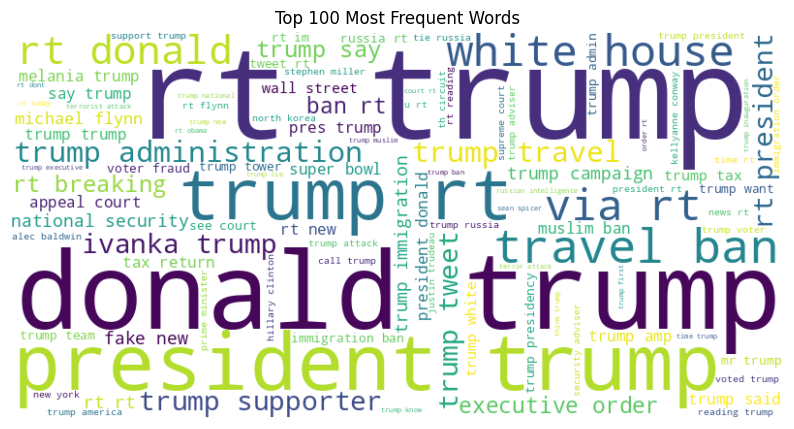

In [10]:
# Visualize: Word Cloud
all_words = ' '.join(data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()

### **Task 2: Tokenization & Padding**

In [11]:
# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['sentiment_encoded'], test_size=0.2, random_state=42)

In [13]:
# Tokenization
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)  # Fit only on training data
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [14]:
# Percentile-based padding
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))  # 95th percentile
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# === Task 3: Model Building ===

In [15]:
# Define function to build models (binary classification)
def build_rnn_model(vocab_size, embedding_dim=128, max_len=max_len):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
        SimpleRNN(64),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [17]:
def build_lstm_model(vocab_size, embedding_dim=128, max_len=max_len):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [18]:
# Build models
rnn_model = build_rnn_model(vocab_size)
lstm_model = build_lstm_model(vocab_size)

# === Task 4: Training & Evaluation ===

In [19]:
# Training setup
checkpoint_rnn = ModelCheckpoint('rnn_best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
checkpoint_lstm = ModelCheckpoint('lstm_best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

In [20]:
# Train RNN model
rnn_history = rnn_model.fit(
    X_train_pad, y_train, epochs=10, batch_size=64,
    validation_data=(X_test_pad, y_test), callbacks=[checkpoint_rnn, early_stop]
)

Epoch 1/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9185 - loss: 0.2067
Epoch 1: val_accuracy improved from -inf to 0.95522, saving model to rnn_best_model.h5


23127/23127 ━━━━━━━━━━━━━━━━━━━━ 102s 4ms/step - accuracy: 0.9185 - loss: 0.2067 - val_accuracy: 0.9552 - val_loss: 0.1288
Epoch 2/10
23116/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9611 - loss: 0.1123
Epoch 2: val_accuracy improved from 0.95522 to 0.95752, saving model to rnn_best_model.h5


23127/23127 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.9611 - loss: 0.1123 - val_accuracy: 0.9575 - val_loss: 0.1205
Epoch 3/10
23112/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9669 - loss: 0.0969
Epoch 3: val_accuracy improved from 0.95752 to 0.96084, saving model to rnn_best_model.h5


23127/23127 ━━━━━━━━━━━━━━━━━━━━ 142s 4ms/step - accuracy: 0.9669 - loss: 0.0969 - val_accuracy: 0.9608 - val_loss: 0.1174
Epoch 4/10
23119/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9696 - loss: 0.0896
Epoch 4: val_accuracy improved from 0.96084 to 0.96169, saving model to rnn_best_model.h5


23127/23127 ━━━━━━━━━━━━━━━━━━━━ 97s 4ms/step - accuracy: 0.9696 - loss: 0.0896 - val_accuracy: 0.9617 - val_loss: 0.1146
Epoch 5/10
23119/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9709 - loss: 0.0861
Epoch 5: val_accuracy did not improve from 0.96169
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 90s 4ms/step - accuracy: 0.9709 - loss: 0.0861 - val_accuracy: 0.9603 - val_loss: 0.1168
Epoch 6/10
23115/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9720 - loss: 0.0839
Epoch 6: val_accuracy improved from 0.96169 to 0.96225, saving model to rnn_best_model.h5


23127/23127 ━━━━━━━━━━━━━━━━━━━━ 149s 4ms/step - accuracy: 0.9720 - loss: 0.0839 - val_accuracy: 0.9623 - val_loss: 0.1143
Epoch 7/10
23111/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9719 - loss: 0.0835
Epoch 7: val_accuracy did not improve from 0.96225
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - accuracy: 0.9719 - loss: 0.0835 - val_accuracy: 0.9614 - val_loss: 0.1147
Epoch 8/10
23112/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9716 - loss: 0.0850
Epoch 8: val_accuracy did not improve from 0.96225
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 97s 4ms/step - accuracy: 0.9715 - loss: 0.0850 - val_accuracy: 0.9605 - val_loss: 0.1188
Epoch 9/10
23117/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9710 - loss: 0.0868
Epoch 9: val_accuracy did not improve from 0.96225
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 90s 4ms/step - accuracy: 0.9710 - loss: 0.0868 - val_accuracy: 0.9602 - val_loss: 0.1203
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 6.


In [21]:
# Train LSTM model
lstm_history = lstm_model.fit(
    X_train_pad, y_train, epochs=10, batch_size=64,
    validation_data=(X_test_pad, y_test), callbacks=[checkpoint_lstm, early_stop]
)

Epoch 1/10
23121/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9244 - loss: 0.1914
Epoch 1: val_accuracy improved from -inf to 0.96286, saving model to lstm_best_model.h5


23127/23127 ━━━━━━━━━━━━━━━━━━━━ 152s 6ms/step - accuracy: 0.9244 - loss: 0.1914 - val_accuracy: 0.9629 - val_loss: 0.1071
Epoch 2/10
23124/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9681 - loss: 0.0932
Epoch 2: val_accuracy improved from 0.96286 to 0.96866, saving model to lstm_best_model.h5


23127/23127 ━━━━━━━━━━━━━━━━━━━━ 148s 6ms/step - accuracy: 0.9681 - loss: 0.0932 - val_accuracy: 0.9687 - val_loss: 0.0927
Epoch 3/10
23118/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9753 - loss: 0.0731
Epoch 3: val_accuracy improved from 0.96866 to 0.97113, saving model to lstm_best_model.h5


23127/23127 ━━━━━━━━━━━━━━━━━━━━ 151s 7ms/step - accuracy: 0.9753 - loss: 0.0731 - val_accuracy: 0.9711 - val_loss: 0.0862
Epoch 4/10
23123/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9798 - loss: 0.0600
Epoch 4: val_accuracy improved from 0.97113 to 0.97140, saving model to lstm_best_model.h5


23127/23127 ━━━━━━━━━━━━━━━━━━━━ 199s 6ms/step - accuracy: 0.9798 - loss: 0.0600 - val_accuracy: 0.9714 - val_loss: 0.0876
Epoch 5/10
23119/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9831 - loss: 0.0509
Epoch 5: val_accuracy improved from 0.97140 to 0.97148, saving model to lstm_best_model.h5


23127/23127 ━━━━━━━━━━━━━━━━━━━━ 151s 7ms/step - accuracy: 0.9831 - loss: 0.0509 - val_accuracy: 0.9715 - val_loss: 0.0895
Epoch 6/10
23126/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9858 - loss: 0.0431
Epoch 6: val_accuracy improved from 0.97148 to 0.97176, saving model to lstm_best_model.h5


23127/23127 ━━━━━━━━━━━━━━━━━━━━ 201s 6ms/step - accuracy: 0.9858 - loss: 0.0431 - val_accuracy: 0.9718 - val_loss: 0.0905
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [22]:
# Evaluate models
def evaluate_model(model, X_test_pad, y_test, label_encoder):
    y_pred = model.predict(X_test_pad)
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()
    accuracy = accuracy_score(y_test, y_pred_classes)
    cm = confusion_matrix(y_test, y_pred_classes)
    # Convert label_encoder.classes_ to strings to avoid TypeError
    target_names = [str(cls) for cls in label_encoder.classes_]  # Convert 0, 1 to "0", "1"
    cr = classification_report(y_test, y_pred_classes, target_names=target_names)
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)
    return accuracy, cm, cr

In [23]:
print("\nRNN Model Evaluation:")
rnn_eval = evaluate_model(rnn_model, X_test_pad, y_test, label_encoder)

print("\nLSTM Model Evaluation:")
lstm_eval = evaluate_model(lstm_model, X_test_pad, y_test, label_encoder)


RNN Model Evaluation:
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
Accuracy: 0.9623
Confusion Matrix:
 [[241727   6836]
 [  7131 114331]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97    248563
           1       0.94      0.94      0.94    121462

    accuracy                           0.96    370025
   macro avg       0.96      0.96      0.96    370025
weighted avg       0.96      0.96      0.96    370025


LSTM Model Evaluation:
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
Accuracy: 0.9711
Confusion Matrix:
 [[243738   4825]
 [  5857 115605]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    248563
           1       0.96      0.95      0.96    121462

    accuracy                           0.97    370025
   macro avg       0.97      0.97      0.97    370025
weighted avg       0.97      0.97      0.97    370025



# === Task 5: Visualization ===

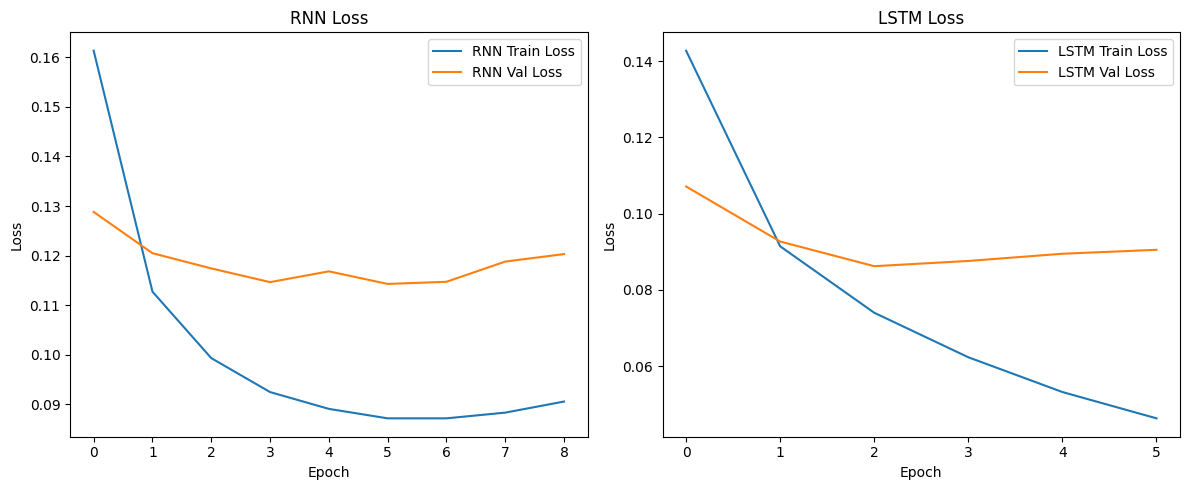

In [24]:
# Plot training vs validation loss
plt.figure(figsize=(12, 5))

# RNN
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Val Loss')
plt.title('RNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# LSTM
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

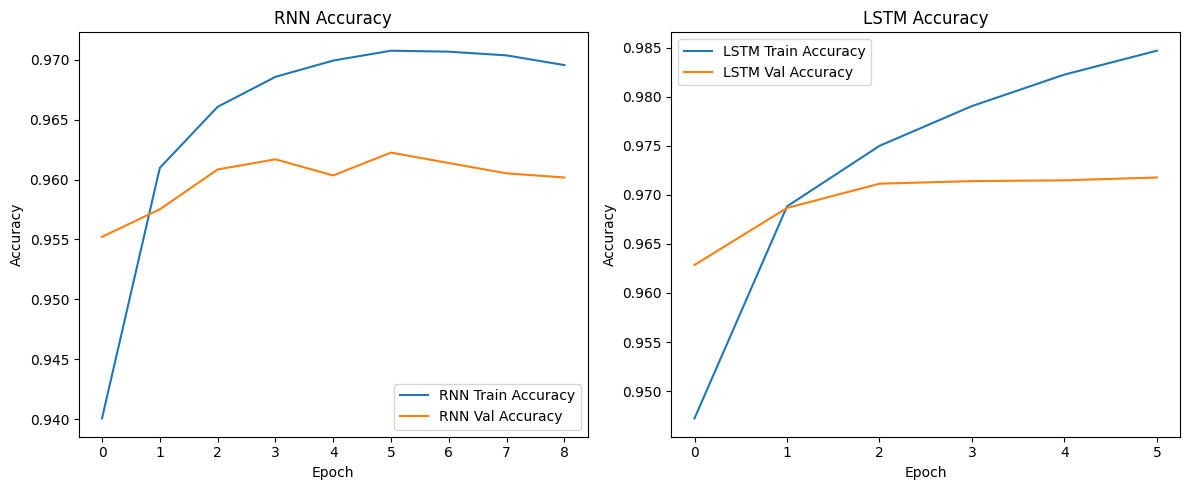

In [25]:
# Plot accuracy
plt.figure(figsize=(12, 5))

# RNN
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='RNN Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Val Accuracy')
plt.title('RNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# LSTM
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# === Task 6: Real-Time Prediction (Colab Input) ===

In [26]:
# Function for real-time prediction
def predict_sentiment(text, tokenizer, model, max_len, label_encoder):
    # Clean and preprocess text
    cleaned_text = preprocess_text(text)
    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    # Predict
    pred = model.predict(padded)
    pred_class = (pred > 0.5).astype(int)[0][0]
    return label_encoder.inverse_transform([pred_class])[0]

# Interactive prediction in Colab
print("\nEnter a tweet for sentiment prediction (type 'exit' to stop):")
while True:
    user_input = input("Tweet: ")
    if user_input.lower() == 'exit':
        break
    if user_input.strip() == '':
        print("Please enter a valid tweet.")
        continue
    # Predict with LSTM model (you can switch to rnn_model)
    sentiment = predict_sentiment(user_input, tokenizer, lstm_model, max_len, label_encoder)
    print(f"Predicted Sentiment: {sentiment}")


Enter a tweet for sentiment prediction (type 'exit' to stop):
Tweet: exit
